In [1]:
%pylab --no-import-all inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


# One bend benchkark

Beam parameters from Table I of 

Y. Cai and Y. Ding
PHYS. REV. ACCEL. BEAMS 23, 014402 (2020)
https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.23.014402



In [2]:
import sys
sys.path.append('../../../')

import csr2d.core2
from csr2d.kick2 import csr1d_steady_state_kick_calc
from csr2d.dist import gauss

In [3]:
import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

In [4]:
Q = 1e-9
gamma = 9804.
sigma_z = 20e-6

twiss_beta_x = 5.19
norm_emit_x = 1e-6
sigma_x = np.sqrt( twiss_beta_x * norm_emit_x/gamma)
rho = 10.34
energy =gamma * mec2

beta2 = (1 - 1/gamma**2)
beta = np.sqrt(1 - 1/gamma**2)
p0c = gamma*beta*mec2

Nb = Q/e_charge

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * mec2 *(sigma_z/abs(rho))**(2/3) / sigma_z**2

kick_factor = r_e * Nb / gamma 

print(f"""
Q       : {Q} C
sigma_x : {sigma_x} m
sigma_z : {sigma_z} m
rho     : {rho} m
gamma   : {gamma}
W0      : {W0:.3e} eV/m
""")


Q       : 1e-09 C
sigma_x : 2.3008167354091462e-05 m
sigma_z : 2e-05 m
rho     : 10.34 m
gamma   : 9804.0
W0      : 3.488e+06 eV/m



In [5]:
# Overtaking length
# Steady-state s into bend for wake to span [-3 sigma, 3 sigma ] (m)
np.cbrt(24 * (6*sigma_z) / rho) * rho

0.6752706207064715

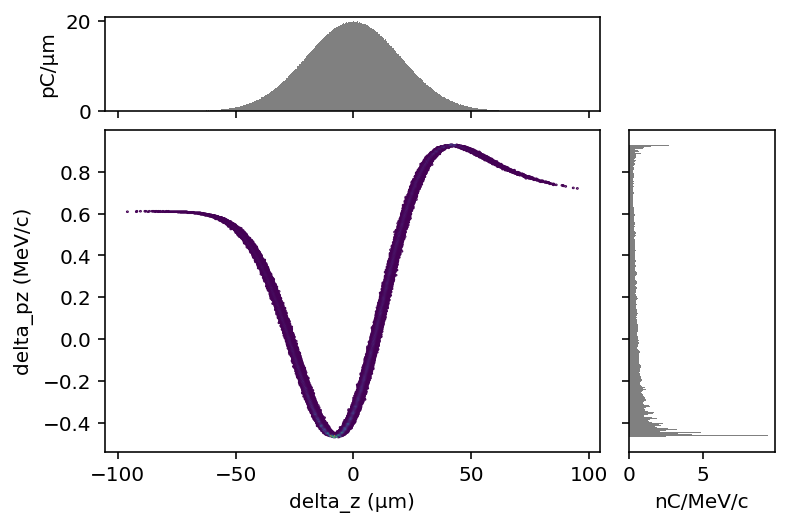

In [6]:
from pmd_beamphysics import ParticleGroup, particle_paths

# Length of sampling part of the bend
STEP = 0.5

P1 = ParticleGroup('END_csr1d.h5')
P1.drift_to_t()
P1.plot('delta_z', 'delta_pz')

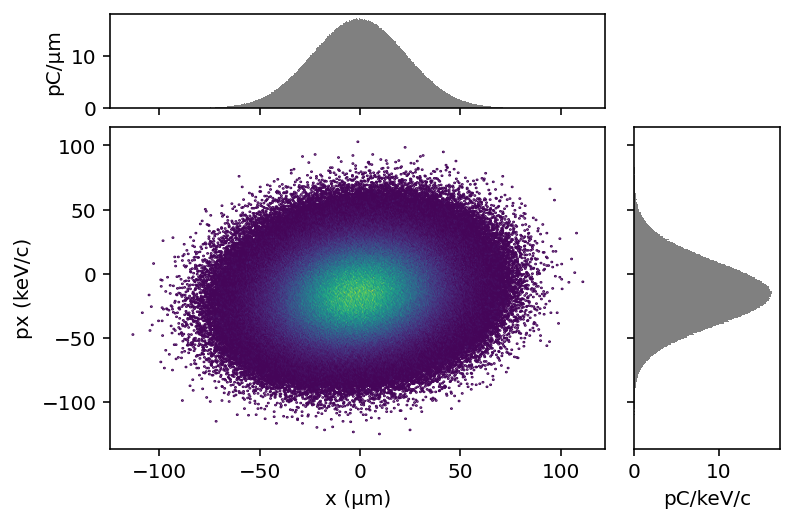

In [7]:
P1.plot('x', 'px')

In [8]:
P1['delta_energy'].ptp() / STEP / W0, P1['sigma_z']*1e6, P1['norm_emit_x']

(0.8016535766481965, 20.02894989532598, 1.1059241780863932e-06)

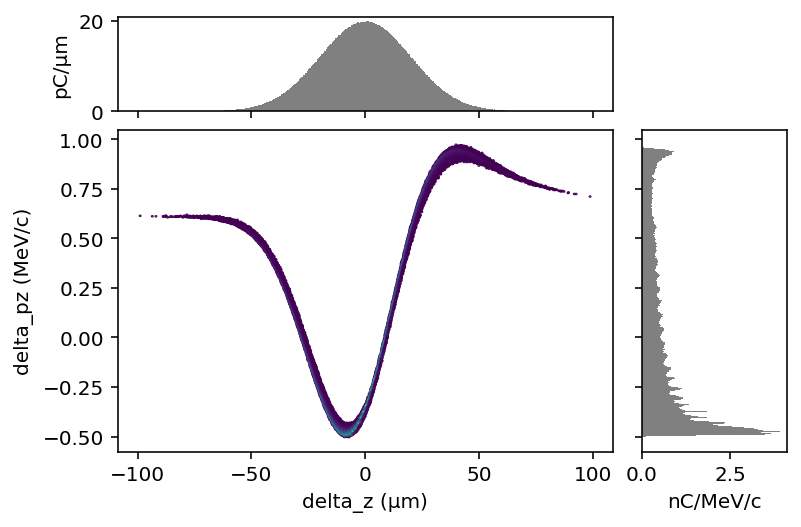

In [9]:
P3 = ParticleGroup('END_csr3d.h5')
P3.drift_to_t()
P3.plot('delta_z', 'delta_pz')

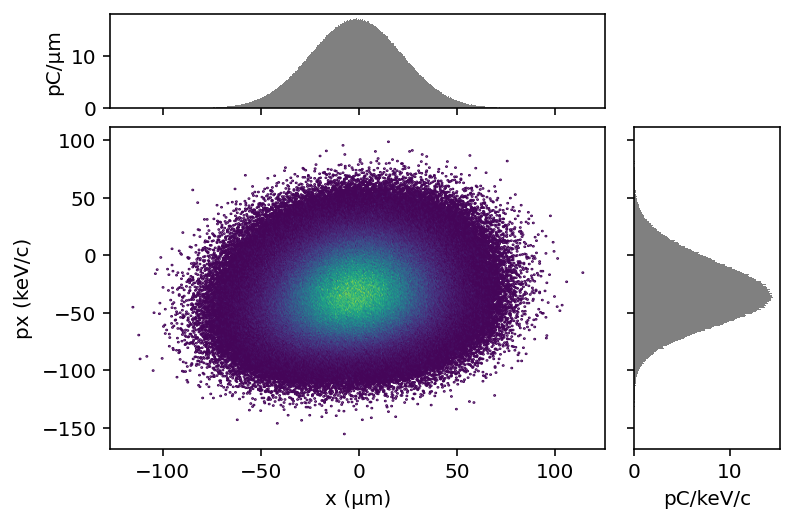

In [10]:
P3.plot('x', 'px')

In [11]:
P1['delta_energy'].ptp() / STEP / W0, P1['sigma_z']*1e6, P1['norm_emit_x']

(0.8016535766481965, 20.02894989532598, 1.1059241780863932e-06)

In [12]:
# Alternative test
# P4 = ParticleGroup('END_csr3d.h5')
# P4.drift_to_t()
# P4.plot('delta_z', 'delta_pz')

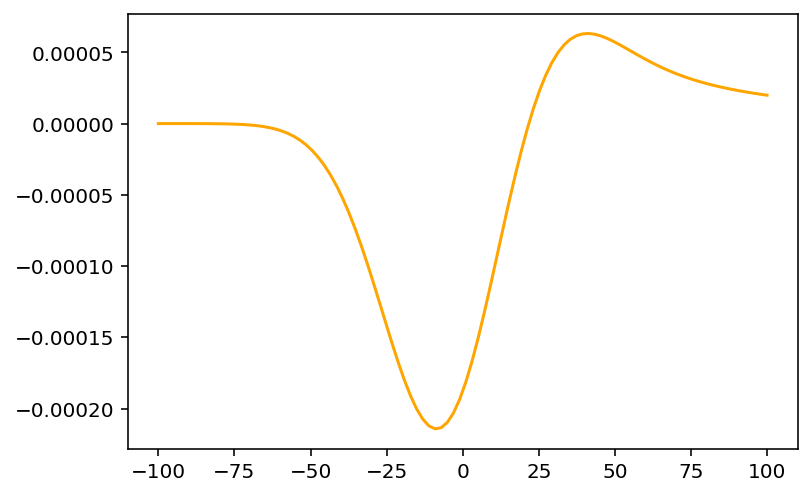

In [13]:
# 1D CSR steady state wake
zvec1 = np.linspace(-5*sigma_z, 5*sigma_z, 100)
weights = gauss(zvec1, sigma=sigma_z)
weights = weights* Q/weights.sum()
SS = csr1d_steady_state_kick_calc(zvec1, weights, rho=rho, normalized_units=False)
plt.plot(SS['zvec']*1e6, SS['wake']/p0c*STEP, color='orange', label='1D Theory')

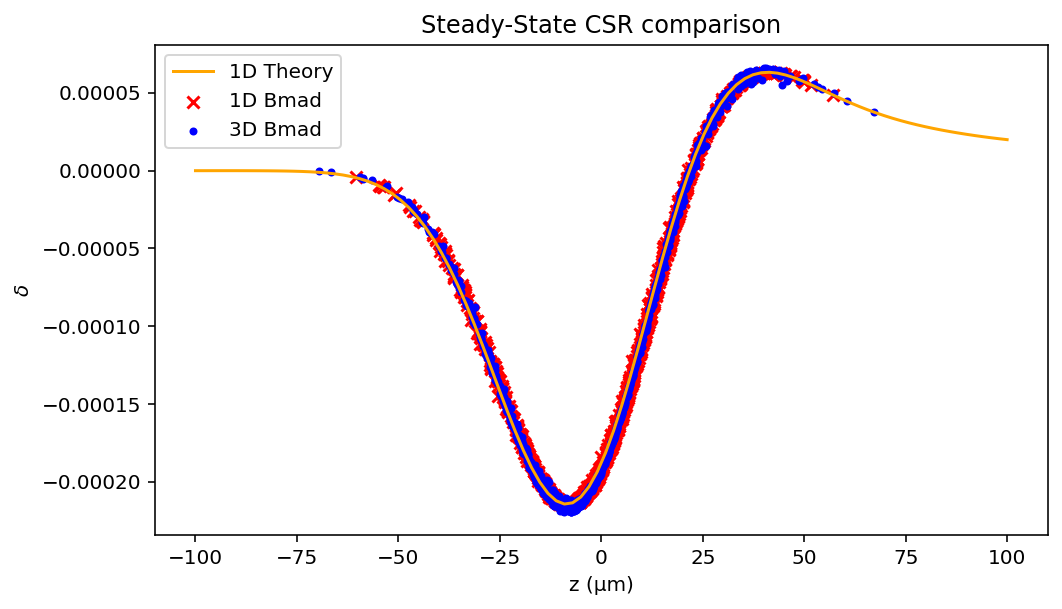

In [14]:


fig, ax = plt.subplots(figsize=(8,4.5))
skip = 1000
ax.scatter(P1.z[::skip]*1e6, P1.p[::skip]/p0c-1, label='1D Bmad', marker='x', color='red')
ax.scatter(P3.z[::skip]*1e6, P3.p[::skip]/p0c-1, label='3D Bmad', marker='.', color='blue')
#ax.scatter(P4.z[::skip]*1e6, (P4.p[::skip]/my_p0c -1), label='3D new', marker='.')


ax.plot(SS['zvec']*1e6, SS['wake']/p0c*STEP, color='orange', label='1D Theory')

ax.set_title('Steady-State CSR comparison')
ax.set_xlabel('z (µm)')
ax.set_ylabel(r'$\delta$')
ax.legend()